# NETSET data parser

In [102]:
#initialize
%run init.py

Set path

In [103]:
path = 2 #set database path
#online path = 0
#backup path = 1
#local path  = 2

In [104]:
if path==2: pathurl='E:/Dropbox/Public/datarepo/netset/'
else: pathurl='https://dl.dropboxusercontent.com/u/531697/datarepo/netset/'

## EIA

In [105]:
#EIA
def eia_parse(url,fuel,datatype,unitconverter,end,additive=False):
    eia=pd.read_excel(url)
    eia=eia.drop(eia.index[:1]).T.set_index([1]).T
    eia.columns=['Country','Drop']+range(end+1-len(eia.columns)+2,end+1)
    eia=eia.drop('Drop',axis=1).drop(eia.index[:1]).set_index('Country')
    
    #save data
    global data
    for country in eia.index:
        if cnc(country) in data:
            for year in set(eia.columns):
                if eia.loc[country][year]=='--': number = np.NaN
                else: number=eia.loc[country][year]
                try: 
                    if additive: data[cnc(country)][year]['energy'][fuel][datatype]['eia']+=number*unitconverter
                    else: data[cnc(country)][year]['energy'][fuel][datatype]['eia']=number*unitconverter
                except: pass
            if country+' (Offshore)' in eia.index:
                for year in set(eia.columns):
                    if eia.loc[country+' (Offshore)'][year]=='--': number = np.NaN
                    else: number=eia.loc[country+' (Offshore)'][year]
                    try: data[cnc(country)][year]['energy'][fuel][datatype]['eia']+=number*unitconverter
                    except: pass

## BP

In [106]:
#BP
def bp_parse(sheet,fuel,datatype,unitconverter,end,additive=False):
    if path==0: url='http://www.bp.com/content/dam/bp/excel/energy-economics/statistical-review-2015/bp-statistical-review-of-world-energy-2015-workbook.xlsx'
    else: url=pathurl+'db/bp-statistical-review-of-world-energy-2015-workbook.xlsx'
    bp=pd.read_excel(url,sheetname=sheet)
    bp=bp.drop(bp.index[:1]).T.set_index([1]).T
    bp.columns=['Country']+range(end+1-len(bp.columns)+3,end+1)+['Drop1','Drop2']
    bp=bp.drop('Drop1',axis=1).drop('Drop2',axis=1).drop(bp.index[:1]).set_index('Country').dropna(axis=0, how='all')
    
    #save data
    global data
    for country in bp.index:
        if cnc(country) in data:
            for year in set(bp.columns):
                if bp.loc[country][year]==u'n/a': number = np.NaN
                else: number=bp.loc[country][year]
                try: 
                    if additive: data[cnc(country)][year]['energy'][fuel][datatype]['bp']+=number*unitconverter
                    else: data[cnc(country)][year]['energy'][fuel][datatype]['bp']=number*unitconverter
                except: pass

## AVG (Average)

In [107]:
#AVG
def avg_parse(fuel,datatype):
    for country in data:
        for year in data[country]:
            if not np.isnan(data[country][year]['energy'][fuel][datatype].values()).any():
                data[country][year]['energy'][fuel][datatype]['avg']=np.mean(data[country][year]['energy'][fuel][datatype].values())
            else: data[country][year]['energy'][fuel][datatype]['avg']=np.NaN

#NAVG - average ignoring nans - just take the average of whatever data is available
def navg_parse(fuel,datatype):
    for country in data:
        for year in data[country]:
            if not np.isnan(data[country][year]['energy'][fuel][datatype].values()).all():
                data[country][year]['energy'][fuel][datatype]['navg']=np.nanmean(data[country][year]['energy'][fuel][datatype].values())
            else: data[country][year]['energy'][fuel][datatype]['navg']=np.NaN

## Global

In [108]:
def parse(url,sheet,fuel,datatype,units,end,additive=False,onlyaverage=0): #onlyaverage 0=all, 1=only data, 2=only average
    if not additive: 
        if onlyaverage!=2:
            reset(fuel,datatype)
    if onlyaverage!=2:
        if url!='none':
            eia_parse(url,fuel,datatype,units['eia'],end['eia'],additive)
        if sheet!='none':
            bp_parse(sheet,fuel,datatype,units['bp'],end['bp'],additive)
    if onlyaverage!=1:
        avg_parse(fuel,datatype)
        navg_parse(fuel,datatype)

# Parse primary energy production and consumption data

Primary energy is energy extracted from the primary source. That could be the amount of energy of oil extracted from the ground or the amount of potential energy of the water. Combustible energy sources (fossils+biofuels) are all primary energy sources, as well as renewables and nuclear electricity.

The typical energy stages that we consider here are:

| Primary  | Secondary  | Tertiary  | Quaternary  |
|---|---|---|---|
| Energy from primary (direct) sources: Renewable & Nuclear, Fossil Fuels & Biofuels  | Electricity | Intermediate energy between two electricity stages: Storage and Power-to-liquid | Regenerated Electricity  |

It is assumed that energy can only stored in primary form (e.g. oil or water potential, etc.) or tertiary (batteries, compressed air (CAES), liquids). Therefore at the primary and tertiary energy stage, we will report both production and consumption data, but at other stages, we only report consumption values.

# Fossils

## oil

In [109]:
#parse data

fuel='oil'
units={'bp':kbpd_to_TWh,'eia':kbpd_to_TWh}
end={'bp':2014,'eia':2014}

#oil prod
if path==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=5&pid=53&pdid=53,55,57,58,59,56,54,62,63,64,65,66,67,68&aid=1&cid=regions&syid=1980&eyid=2014&form=&defaultid=3&typeOfUnit=STDUNIT&unit=TBPD&products='
else: url=pathurl+'db/Total_Oil_Supply_(Thousand_Barrels_Per_Day).xls'
sheet=u'Oil Production – Barrels'
parse(url,sheet,fuel,'prod',units,end)

#oil cons
if path==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=5&pid=5&pdid=5,62,63,64,65,66,67,68&aid=2&cid=regions&syid=1980&eyid=2014&form=&defaultid=3&typeOfUnit=STDUNIT&unit=TBPD&products='
else: url=pathurl+'db/Total_Petroleum_Consumption_(Thousand_Barrels_Per_Day).xls'
sheet=u'Oil Consumption – Barrels'
parse(url,sheet,fuel,'cons',units,end)

#oil res
if path==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=5&pid=57&pdid=57&aid=6&cid=regions&syid=1980&eyid=2015&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BB&products='
else: url=pathurl+'db/Crude_Oil_Proved_Reserves_(Billion_Barrels).xls'
units={'bp':Gboe_to_TWh,'eia':Gboe_to_TWh} #redefine units
end={'bp':2014,'eia':2015}
sheet=u'Oil - Proved reserves history'
parse(url,sheet,fuel,'res',units,end)

#oil emi
if path==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=5&pid=5&pdid=5&aid=8&cid=regions&syid=1980&eyid=2013&form=&defaultid=3&typeOfUnit=STDUNIT&unit=MMTCD&products='
else: url=pathurl+'db/CO2_Emissions_from_the_Consumption_of_Petroleum_(Million_Metric_Tons).xls'
units={'bp':3.07*kbpd_to_TWh/mtoe_to_TWh,'eia':1} #redefine units
end={'bp':2014,'eia':2013}
sheet=u'Oil Consumption – Barrels'
parse(url,sheet,fuel,'emi',units,end)

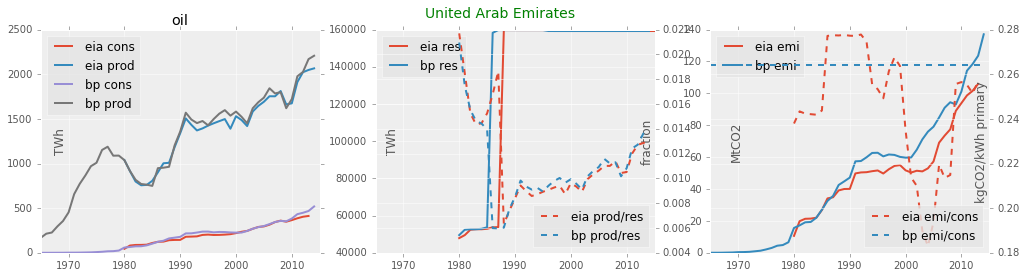

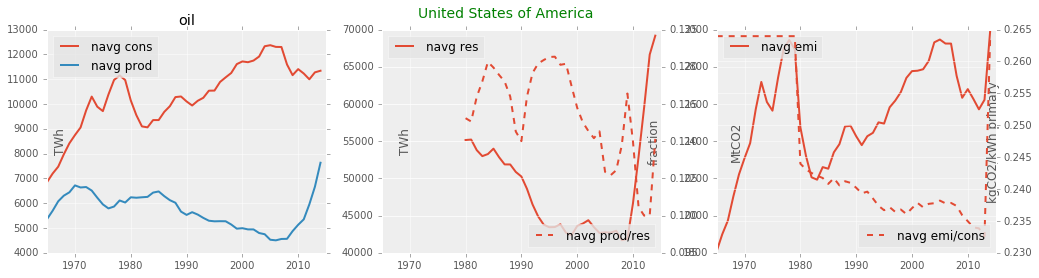

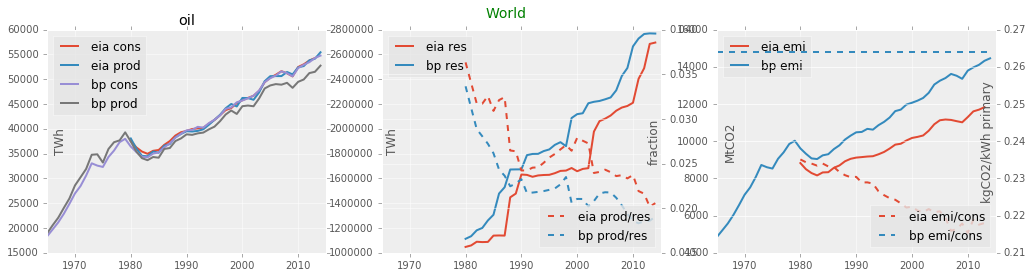

In [110]:
plotter('United Arab Emirates',fuel,dbs) #change 'avg' to {'bp'}, 'eia', 'all' or any set such as {'bp','avg'}
plotter('United States of America',fuel,'navg')
plotter('World',fuel,dbs)
#dbs={'bp','eia'}
#avg is average where only both eia and bp data is available, null otherwise
#navg is NaN-average which takes a value of only one dataset where only dataset is avialble, avg elsewhere

## gas

In [111]:
fuel='gas'
units={'bp':bcf_to_TWh*365.25,'eia':bcf_to_TWh}
end={'bp':2014,'eia':2014}

#gas prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=3&pid=26&pdid=3,43,48,24,26&aid=1&cid=regions&syid=1980&eyid=2014&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BCF&products='
else: url=pathurl+'db/Dry_Natural_Gas_Production_(Billion_Cubic_Feet).xls'
sheet=u'Gas Production – Bcf'
parse(url,sheet,fuel,'prod',units,end)

#gas cons
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=3&pid=26&pdid=26&aid=2&cid=regions&syid=1980&eyid=2014&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BCF&products='
else: url=pathurl+'db/Dry_Natural_Gas_Consumption_(Billion_Cubic_Feet).xls'
sheet=u'Gas Consumption – Bcf'
parse(url,sheet,fuel,'cons',units,end)

#gas res
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=3&pid=3&pdid=3&aid=6&cid=regions&syid=1980&eyid=2015&form=&defaultid=3&typeOfUnit=STDUNIT&unit=TCF&products='
else: url=pathurl+'db/Proved_Reserves_of_Natural_Gas_(Trillion_Cubic_Feet).xls'
units={'bp':tcm_to_TWh,'eia':tcf_to_TWh} #redefine units
end={'bp':2014,'eia':2015}
sheet=u'Gas - Proved reserves history '
parse(url,sheet,fuel,'res',units,end)

#gas emi
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=3&pid=3&pdid=3,51,52&aid=8&cid=regions&syid=1980&eyid=2013&form=&defaultid=3&typeOfUnit=STDUNIT&unit=MMTCD&products='
else: url=pathurl+'db/C02_Emissions_from_the_Consumption_and_Flaring_of_Natural_Gas_(Million_Metric_Tons).xls'
units={'bp':2.35*bcf_to_TWh*365.25/mtoe_to_TWh,'eia':1} #redefine units
end={'bp':2014,'eia':2013}
sheet=u'Gas Consumption – Bcf'
parse(url,sheet,fuel,'emi',units,end)

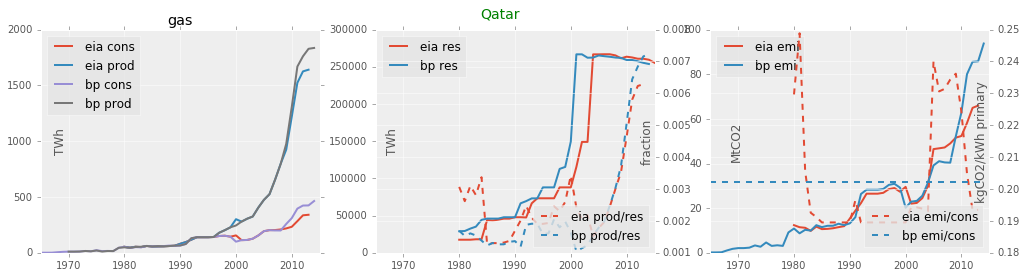

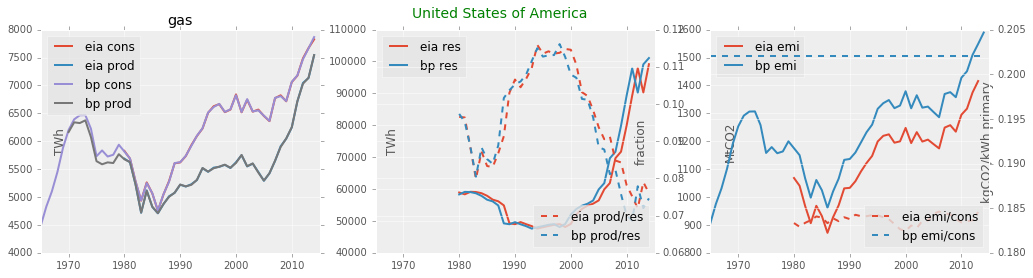

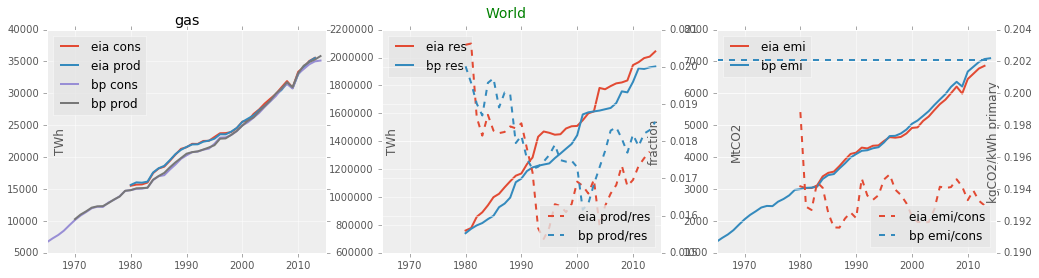

In [112]:
plotter('Qatar','gas',dbs)
plotter('United States of America','gas',dbs)
plotter('World','gas',dbs)

## coal

In [113]:
fuel='coal'
units={'bp':mtoe_to_TWh,'eia':qbtu_to_TWh}
end={'bp':2014,'eia':2012}

#coal prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=1&pid=7&pdid=7,9,11,12,14,17,18,21&aid=1&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=BTUUNIT&unit=QBTU&products='
else: url=pathurl+'db/Total_Primary_Coal_Production_(Quadrillion_Btu).xls'
sheet=u' Coal Production - Mtoe'
parse(url,sheet,fuel,'prod',units,end)

#coal cons
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=1&pid=1&pdid=1&aid=2&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=BTUUNIT&unit=QBTU&products='
else: url=pathurl+'db/Total_Coal_Consumption_(Quadrillion_Btu).xls'
sheet=u'Coal Consumption -  Mtoe'
parse(url,sheet,fuel,'cons',units,end)

#coal res
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=1&pid=7&pdid=7,9,14&aid=6&cid=regions&syid=2011&eyid=2011&form=&defaultid=3&typeOfUnit=STDUNIT&unit=MST&products='
else: url=pathurl+'db/Total_Recoverable_Coal_(Million_Short_Tons).xls'
units={'bp':mtcoe_to_TWh,'eia':mstcoe_to_TWh} #redefine units
end={'bp':2014,'eia':2011}
sheet=u'Coal - Reserves'
parse(url,sheet,fuel,'res',units,end,False,1) #don't calculte averages yet, fix db first
#fill bp data for 2011-2013
for i in data.keys():
    for j in range(2011,2014):
        try:
            data[i][j]['energy'][fuel]['res']['bp']=np.NaN
        except: pass
parse(url,sheet,fuel,'res',units,end,False,2) #recalculate averages - last parameter is only average

#coal emi
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=1&pid=1&pdid=1&aid=8&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=MMTCD&products='
else: url=pathurl+'db/CO2_Emissions_from_the_Consumption_of_Coal_(Million_Metric_Tons).xls'
units={'bp':3.96*1,'eia':1} #redefine units
end={'bp':2014,'eia':2012}
sheet=u'Coal Consumption -  Mtoe'
#bp does not report direct emissions values, just consumption + carbon content
parse(url,sheet,fuel,'emi',units,end)

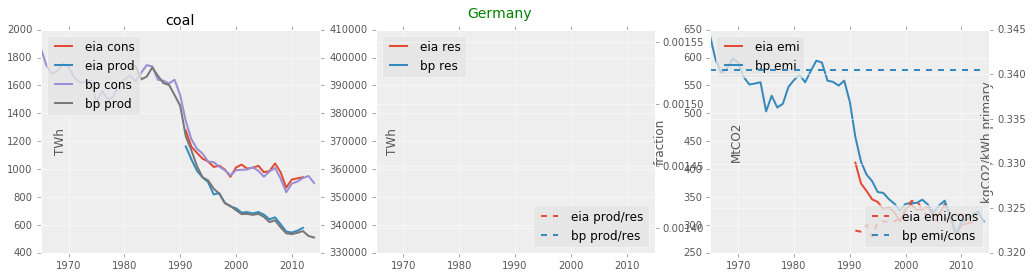

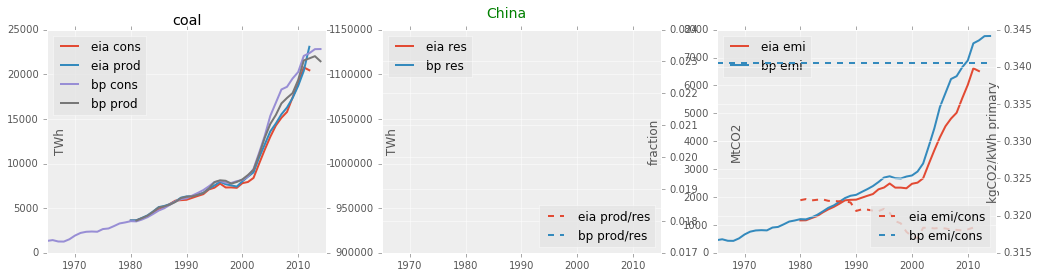

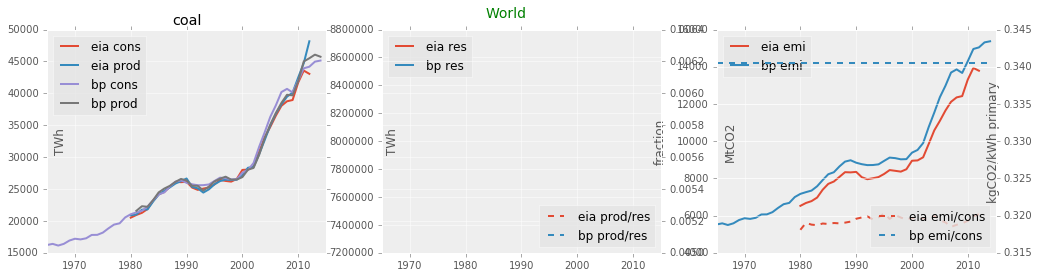

In [114]:
plotter('Germany','coal',dbs)
plotter('China','coal',dbs)
plotter('World','coal',dbs)

# Biofuels

BP only gives production values.

In [115]:
fuel='biofuels'
units={'bp':mtoe_to_TWh/1000,'eia':kbpd_to_TWh}
end={'bp':2018,'eia':2012}

#biofuels prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=79&pid=79&pdid=79,80,81&aid=1&cid=regions&syid=2000&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=TBPD&products='
else: url=pathurl+'db/Total_Biofuels_Production_(Thousand_Barrels_Per_Day).xls'
sheet=u'Biofuels Production - Ktoe'
parse(url,sheet,fuel,'prod',units,end)

#biofuels cons
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=79&pid=79&pdid=79,80,81&aid=2&cid=regions&syid=2000&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=TBPD&products='
else: url=pathurl+'db/Total_Biofuels_Consumption_(Thousand_Barrels_Per_Day).xls'
sheet='none'
parse(url,sheet,fuel,'cons',units,end)

#fill data after 2014
for i in data.keys():
    for j in range(2015,2019):
        try:
            data[i][j]['energy'][fuel]={k:{l:np.NaN for l in (dbs|{'avg','navg'})} for k in datatypes}
        except: pass

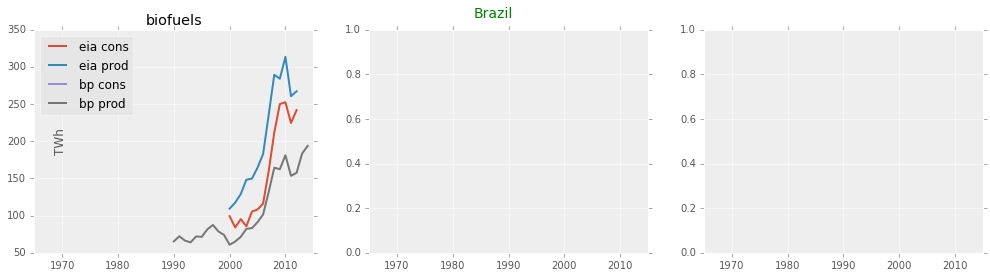

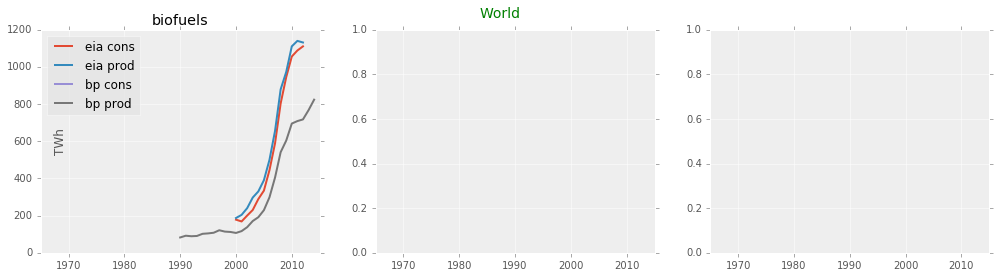

In [116]:
plotter('Brazil','biofuels',dbs)
plotter('World','biofuels',dbs)

# Electricity

Currently electricity production = consumption + losses - imports + exports + (storage = 0)  
Since there is no substantial long-term storage and the losses are quasi-constant around 7%, one call to the database is enough. EIA only gives generation values, while BP only gives consumption values. Strangely, BP consumption values are usually higher than EIA generation values.

## nuclear

In [117]:
fuel='nuclear'
units={'bp':1,'eia':1}
end={'bp':2014,'eia':2013}

#nuclear prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=2&pid=27&pdid=&aid=12&cid=regions&syid=1980&eyid=2013&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Nuclear_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
sheet='none'
parse(url,sheet,fuel,'prod',units,end)

#nuclear cons
url='none'
sheet=u'Nuclear Consumption - TWh'
parse(url,sheet,fuel,'cons',units,end)

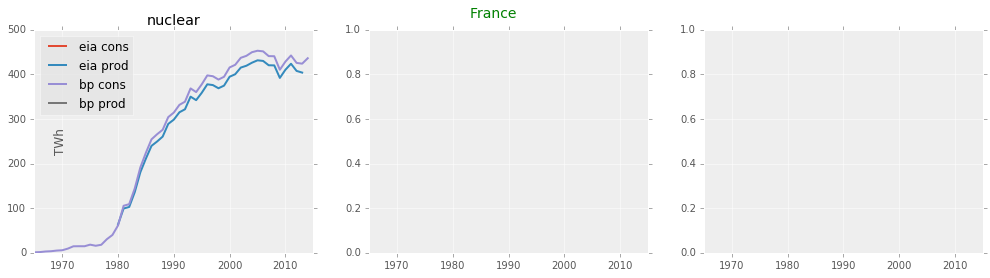

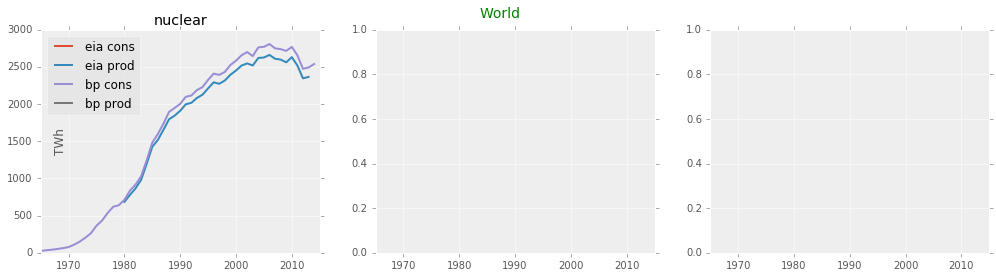

In [118]:
plotter('France','nuclear',dbs)
plotter('World','nuclear',dbs)

## hydro

In [119]:
fuel='hydro'
units={'bp':1,'eia':1}
end={'bp':2014,'eia':2013}

#hydro prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=2&pid=33&pdid=&aid=12&cid=regions&syid=1980&eyid=2013&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Hydroelectricity_Net_Generation_(Billion_Kilowatthours).xls'
sheet='none'
parse(url,sheet,fuel,'prod',units,end)

#hydro cons
url='none'
sheet=u'Hydro Consumption - TWh'
parse(url,sheet,fuel,'cons',units,end)

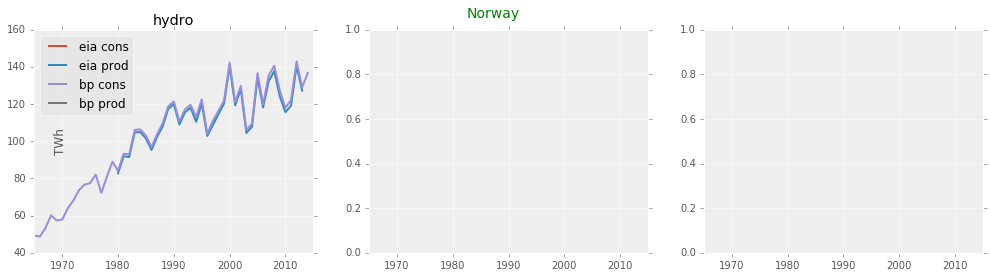

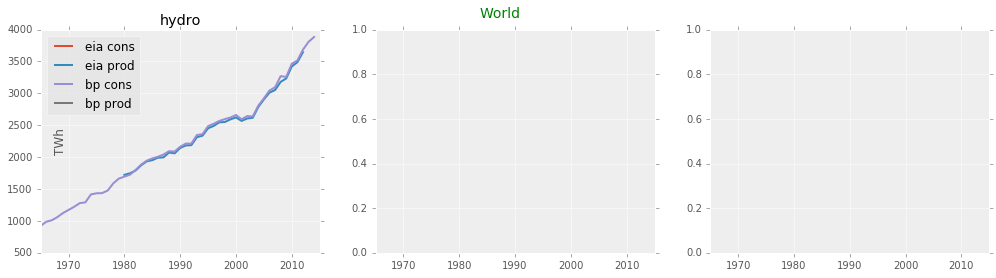

In [120]:
plotter('Norway','hydro',dbs)
plotter('World','hydro',dbs)

## solar

Unfortunately neither of the databases keeps track of CSP and PV sepparately - mostly because CSP deplyoment is very low, when compared to PV. We introduce CSP manually later on in this workbook.

In [121]:
fuel='solar'
units={'bp':1,'eia':1}
end={'bp':2014,'eia':2012}

#solar prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=6&pid=116&pdid=29,33,34,35,37,36,38,116,117&aid=12&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Solar_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
sheet='none'
parse(url,sheet,fuel,'prod',units,end)

#solar cons
url='none'
sheet=u'Solar Consumption - TWh'
parse(url,sheet,fuel,'cons',units,end)

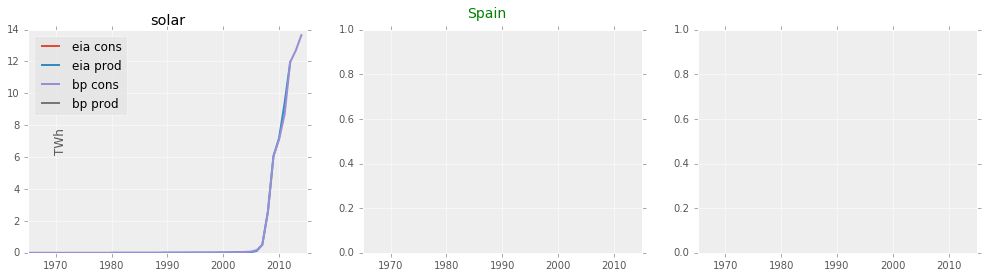

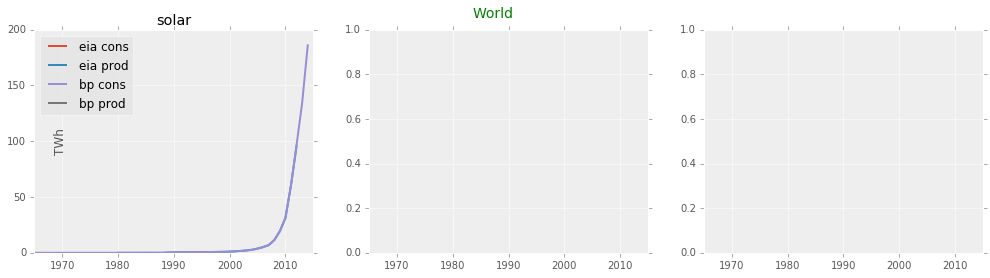

In [122]:
plotter('Spain','solar',dbs)
plotter('World','solar',dbs)

## wind

Onshore and Offshore combined

In [123]:
fuel='wind'
units={'bp':1,'eia':1}
end={'bp':2014,'eia':2012}

#wind prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=6&pid=37&pdid=29,33,34,35,37,36,38,116,117&aid=12&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Wind_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
sheet='none'
parse(url,sheet,fuel,'prod',units,end)

#wind cons
url='none'
sheet=u'Wind Consumption - TWh '
parse(url,sheet,fuel,'cons',units,end)

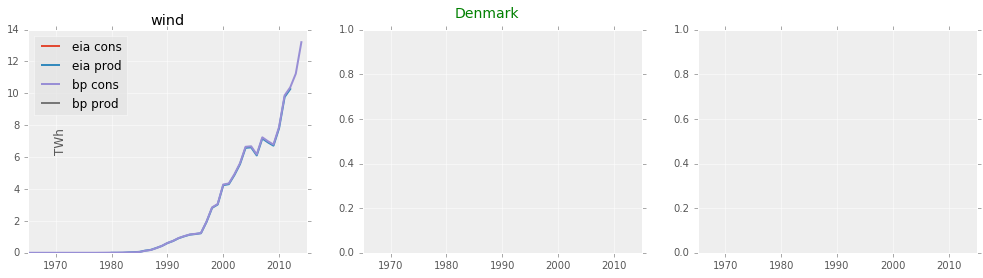

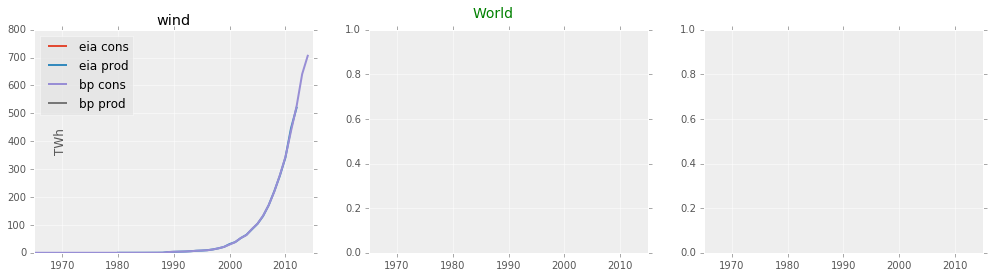

In [124]:
plotter('Denmark','wind',dbs)
plotter('World','wind',dbs)

## geo+other

geothermal, biomass, tidal, wave, waste

In [125]:
fuel='geo_other'
units={'bp':1,'eia':1}
end={'bp':2014,'eia':2012}

#geo+other prod
#geothermal
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=6&pid=35&pdid=29,33,34,35,37,36,38,116,117&aid=12&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Geothermal_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
eia_parse(url,fuel,'prod',units['eia'],end['eia'])
#biomass+waste
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=6&pid=38&pdid=29,33,34,35,37,36,38,116,117&aid=12&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Biomass_and_Waste_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
eia_parse(url,fuel,'prod',units['eia'],end['eia'],True) #set last parameter to True to make operation additive
#tidal+wave
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=6&pid=117&pdid=29,33,34,35,37,36,38,116,117&aid=12&cid=regions&syid=1980&eyid=2012&form=&defaultid=3&typeOfUnit=STDUNIT&unit=BKWH&products='
else: url=pathurl+'db/Tide_and_Wave_Electricity_Net_Generation_(Billion_Kilowatthours).xls'
eia_parse(url,fuel,'prod',units['eia'],end['eia'],True) #set last parameter to True to make operation additive

url='none'
sheet='none'
parse(url,sheet,fuel,'prod',units,end,True)

#geo+other cons
url='none'
sheet=u'Geo Biomass Other - TWh'
parse(url,sheet,fuel,'cons',units,end)

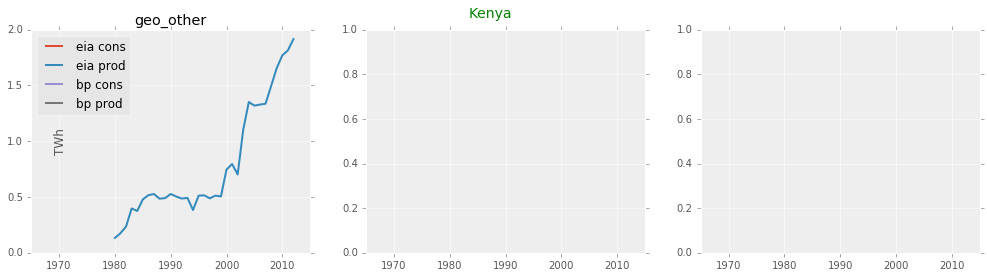

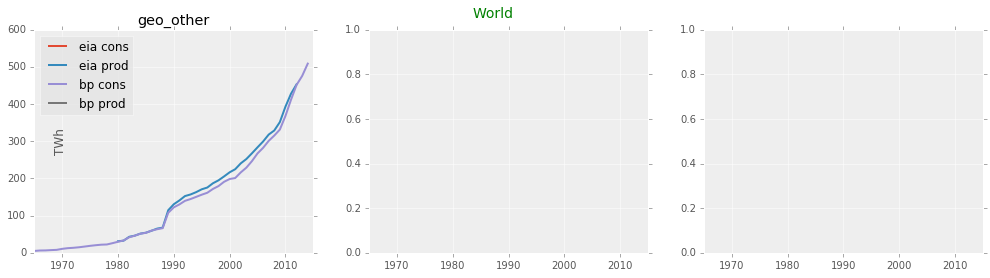

In [126]:
plotter('Kenya','geo_other',dbs)
plotter('World','geo_other',dbs)

# Total primary energy

## Sum components already parsed

This is stored under the key `nrg_sum` in the `data` dictionary.

In [127]:
reset('nrg_sum')
for country in data:
    for year in data[country]:
        for k in {'prod','cons','emi','res'}:
            for j in dbs:
                data[country][year]['energy']['nrg_sum'][k][j]=\
                np.nansum([data[country][year]['energy'][i][k][j] for i in data[country][year]['energy'].keys() if (i not in {'nrg','nrg_sum'})])
                if (data[country][year]['energy']['nrg_sum'][k][j]==0): data[country][year]['energy']['nrg_sum'][k][j]=np.NaN

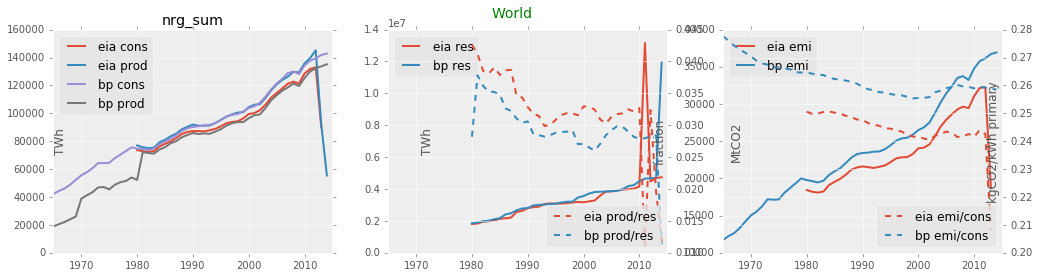

In [128]:
plotter('World','nrg_sum',dbs)

## Parse sum directly from DB

This is stored under the key `nrg` in the `data` dictionary.

In [129]:
fuel='nrg'
units={'bp':mtoe_to_TWh,'eia':qbtu_to_TWh}
end={'bp':2014,'eia':2015}

#total prod
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=44&pid=44&pdid=44&aid=1&cid=regions&syid=1980&eyid=2015&form=&defaultid=3&typeOfUnit=BTUUNIT&unit=QBTU&products='
else: url=pathurl+'db/Total_Primary_Energy_Production_(Quadrillion_Btu).xls'
sheet=u'none'
parse(url,sheet,fuel,'prod',units,end)

#total cons
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=44&pid=44&pdid=44,45,46,47&aid=2&cid=regions&syid=1980&eyid=2015&form=&defaultid=3&typeOfUnit=BTUUNIT&unit=QBTU&products='
else: url=pathurl+'db/Total_Primary_Energy_Consumption_(Quadrillion_Btu).xls'
sheet=u'Primary Energy Consumption '
parse(url,sheet,fuel,'cons',units,end)

#total emi
if path ==0: url='http://www.eia.gov/cfapps/ipdbproject/XMLinclude_3.cfm?tid=90&pid=44&pdid=&aid=8&cid=regions&syid=1980&eyid=2015&form=&defaultid=3&typeOfUnit=STDUNIT&unit=MMTCD&products='
else: url=pathurl+'db/_(Million_Metric_Tons).xls'
units={'bp':1,'eia':1} #redefine units
sheet=u'Carbon Dioxide Emissions'
parse(url,sheet,fuel,'emi',units,end)

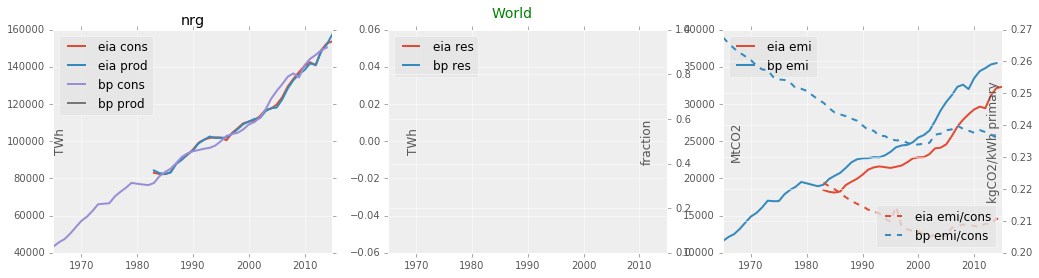

In [130]:
plotter('World','nrg',dbs)

# Stack plots

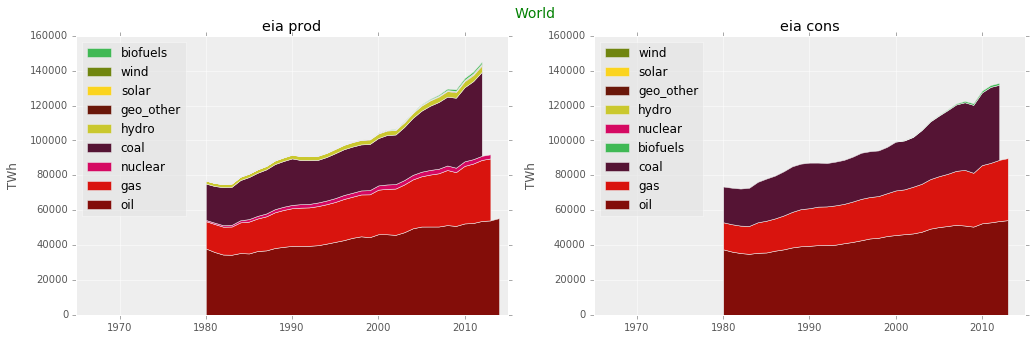

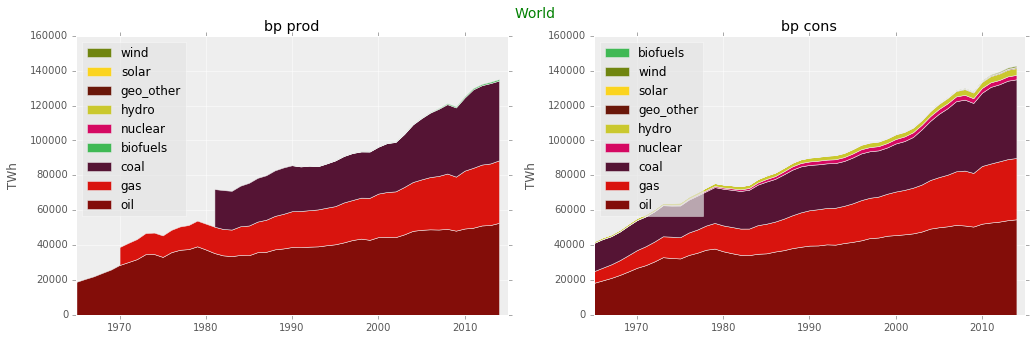

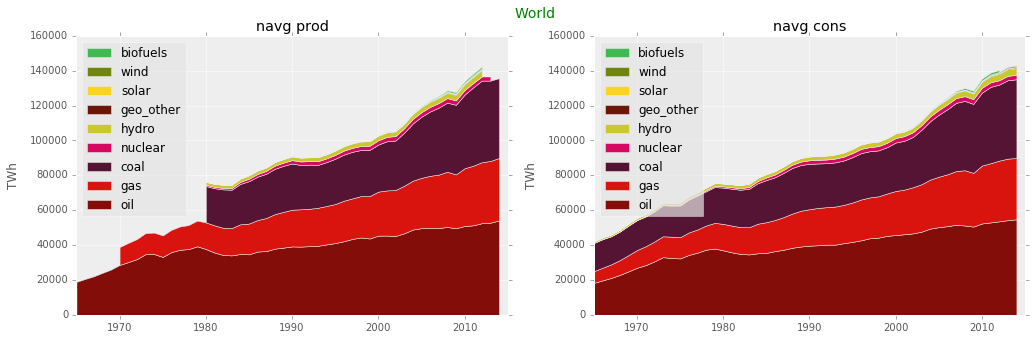

In [131]:
stackplotter('World','eia','all','all')
stackplotter('World','bp','all','all')
stackplotter('World','navg','all','all')

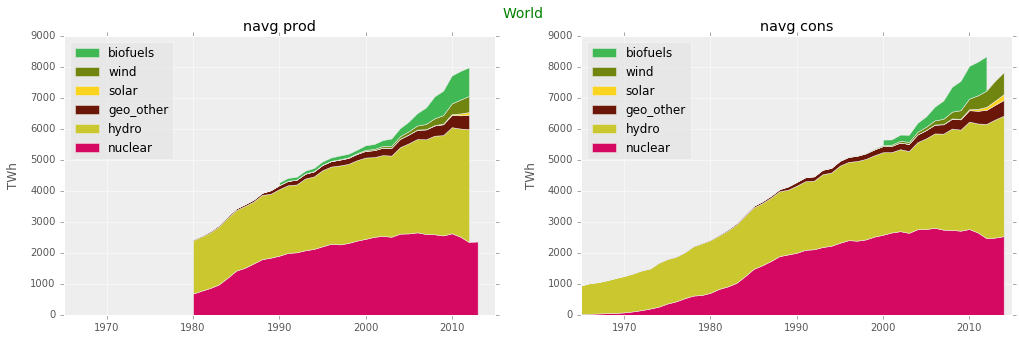

In [132]:
stackplotter('World','navg','all',['hydro','nuclear','geo_other','biofuels','solar','wind'])

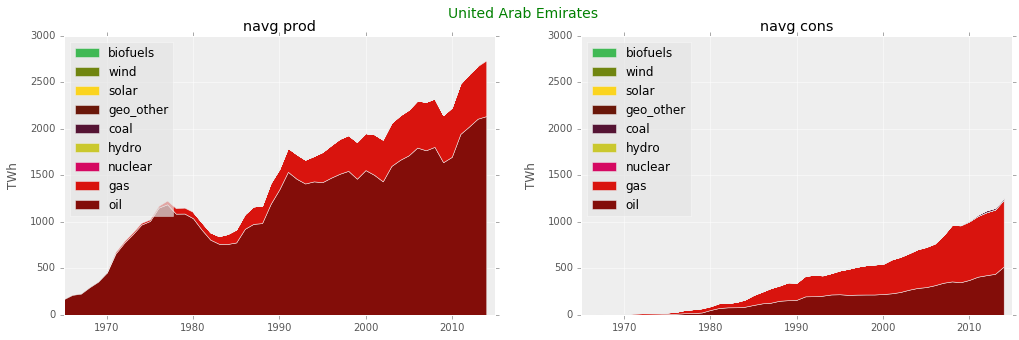

In [133]:
stackplotter('United Arab Emirates','navg','all','all')

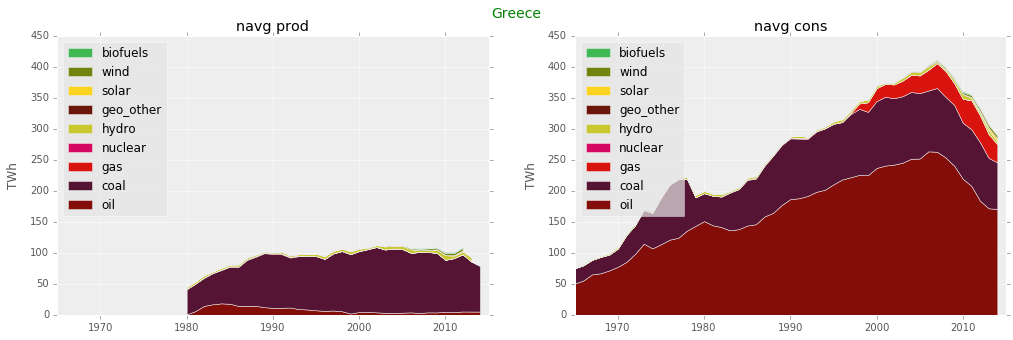

In [134]:
stackplotter('Greece','navg','all','all')

# Save data

For postprocessing

In [135]:
file(pathurl+'parseroutput.json','w').write(json.dumps(data))

Load - if saved

In [97]:
data=json.loads(file(path+'parseroutput.json','r').read())

For exploration in viz

In [136]:
save('00',db='navg')

# Viz

In [137]:
%%html
<iframe src="http://localhost:8000/netset/#&viz_1&scale_0&scenario_00&start_1965&end_2015&country_Germany"
width=100% height=630 style="background: #fff;"/>